In [1]:
import os
import pickle
import numpy as np
import ollama  # for embedding
import pandas as pd
import random

seed = 42 # Set the seed for reproducibility
np.random.seed(seed) # For NumPy
random.seed(seed) # For Python's built-in random module

In [2]:
%run Q4p_create_prompts.py

Number of RecordIDs with at least one death (1) entry: 554


OSError: [Errno 122] Disk quota exceeded

In [3]:
# Path to the pickle files
pkl_file_train = "Q4p2/Q4p2_patient_descriptions_train.pkl"
pkl_file_test = "Q4p2/Q4p2_patient_descriptions_test.pkl"

# Function to get embeddings and save them after each iteration
def get_embeddings_from_pkl(input_pkl, output_pkl):
    try:
        # Load the data from the pickle file
        with open(input_pkl, "rb") as pkl_file:
            patient_descriptions = pickle.load(pkl_file)

        embeddings = []

        # Loop over each description and generate embeddings
        for i, description in enumerate(patient_descriptions[:]):
            try:
                # Ensure the model is explicitly specified
                response = ollama.embed(input=description, model="gemma2:2b")  # Explicitly specify 'gemma2:2b' as the model
                embedding = response["embeddings"] 
                embeddings.append(embedding)

                # Save the embeddings to the pickle file after each iteration
                with open(output_pkl, "wb") as pkl_file:
                    pickle.dump(embeddings, pkl_file)

                print(f"Processed {i + 1}/{len(patient_descriptions)} descriptions.")

            except Exception as e:
                print(f"Error processing description {i + 1}: {e}")

    except Exception as e:
        print(f"Error loading or processing the pickle file {input_pkl}: {e}")


In [4]:
# Output pickle files for the embeddings
output_pkl_train = "Q4p2/Q4p2_patient_embeddings_train.pkl"
output_pkl_test = "Q4p2/Q4p2_patient_embeddings_test.pkl"

should_run_test = False

if should_run_test:
    # Get embeddings and save them for each pickle file
    get_embeddings_from_pkl(pkl_file_train, output_pkl_train)
    get_embeddings_from_pkl(pkl_file_test, output_pkl_test)

In [5]:
import pickle
import numpy as np
import pandas as pd

def combine_embeddings_from_pkl(pkl_file):
    """
    Loads a .pkl file containing a list of embeddings, combines them into a single numpy array.

    Args:
    - pkl_file (str): The path to the .pkl file containing the list of embeddings.

    Returns:
    - combined_embeddings (numpy.ndarray): The combined embeddings as a single numpy array.
    """
    # Load the embeddings from the .pkl file
    with open(pkl_file, 'rb') as f:
        all_embeddings = pickle.load(f)

    # Convert the list of embeddings into a single numpy array (stacking vertically)
    combined_embeddings = np.vstack(all_embeddings)

    return combined_embeddings




In [6]:
combine_pkl_files = False

if combine_pkl_files:
    combined_embeddings_train = combine_embeddings_from_pkl('Q4p2/Q4p2_patient_embeddings_train.pkl')
    Q4p2_embeddings_train_all = np.vstack([combined_embeddings_train])
    np.save('Q4p2/Q4p2_embeddings_train_all.npy', Q4p2_embeddings_train_all)

    combined_embeddings_test = combine_embeddings_from_pkl('Q4p2/Q4p2_patient_embeddings_test.pkl')
    Q4p2_embeddings_test_all = np.vstack([combined_embeddings_test])
    np.save('Q4p2/Q4p2_embeddings_test_all.npy', Q4p2_embeddings_test_all)
    

In [7]:
Q4p2_embeddings_train_all = np.load('Q4p2/Q4p2_embeddings_train_all.npy')
print(Q4p2_embeddings_train_all)
print(len(Q4p2_embeddings_train_all))

Q4p2_embeddings_test_all = np.load('Q4p2/Q4p2_embeddings_test_all.npy')
print(Q4p2_embeddings_test_all)
print(len(Q4p2_embeddings_test_all))

[[ 1.0940503e-02 -5.8381525e-03 -2.1024609e-02 ... -1.0666425e-02
   8.4423420e-04  1.2592894e-02]
 [ 1.1591841e-02 -4.9974048e-03 -2.1315565e-02 ... -1.0652869e-02
   1.1895294e-03  1.1542927e-02]
 [ 9.8563390e-03 -4.6449504e-03 -2.0226626e-02 ... -8.5605900e-03
   5.0015900e-04  1.2330796e-02]
 ...
 [ 1.0831446e-02 -5.1912470e-03 -2.0493453e-02 ... -1.0655455e-02
   1.5663705e-03  1.2329102e-02]
 [ 8.4534290e-03 -1.5929961e-03 -9.9245790e-03 ...  1.1526255e-03
   6.1066914e-03  1.1148460e-02]
 [ 1.0498305e-02 -5.0185067e-03 -2.2310643e-02 ... -1.0177018e-02
  -8.8316450e-05  1.2698251e-02]]
3997
[[ 1.54280370e-02  3.31087130e-03 -1.96828400e-02 ... -7.96247040e-04
   3.06744040e-03 -2.37591240e-03]
 [ 1.55291020e-02  3.44432800e-03 -2.16084770e-02 ... -2.78112730e-03
   4.51855270e-03 -1.15774690e-03]
 [ 1.49981575e-02  2.57318330e-03 -2.05415990e-02 ...  4.10029980e-04
   3.49132440e-03 -5.19602700e-04]
 ...
 [ 1.57659610e-02  2.01341860e-03 -2.08578840e-02 ... -2.79840660e-04
   3.

In [8]:
X_train = Q4p2_embeddings_train_all

set_a = pd.read_parquet("loaded_data/a_patient_data_NOT_scaled.parquet", engine='pyarrow')
y_train = set_a.groupby('RecordID')['In-hospital_death'].last().values
#y_train = y_train[:len(X_train)]
print(y_train)

print(len(y_train))

[0 0 0 ... 0 1 0]
3997


In [9]:
X_test = Q4p2_embeddings_test_all

set_a = pd.read_parquet("loaded_data/c_patient_data_NOT_scaled.parquet", engine='pyarrow')
y_test = set_a.groupby('RecordID')['In-hospital_death'].last().values
#y_test = y_test[:len(X_test)]
print(y_test)

print(len(y_test))

[0 1 0 ... 0 0 0]
3998


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train a linear probe (logistic regression)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy}")

Test set accuracy: 0.8536768384192096


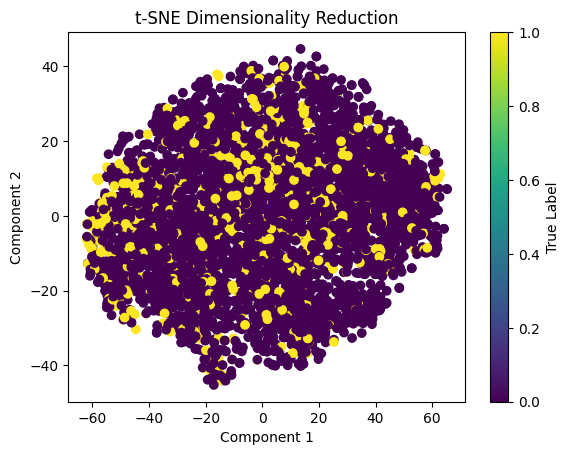

/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


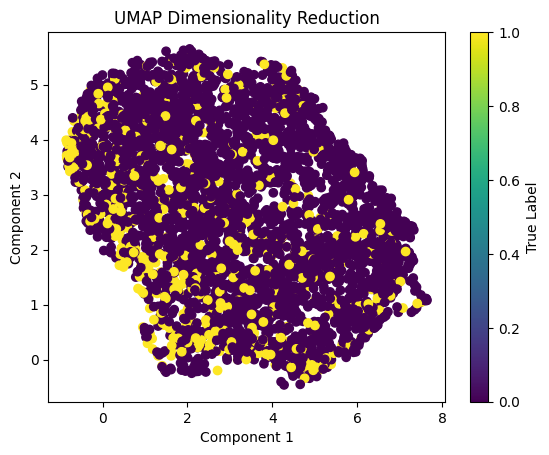

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(X_test)

# Plot the t-SNE result colored by the true labels
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_test, cmap='viridis')
plt.title('t-SNE Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='True Label')  # Show color bar to indicate true labels
plt.show()
plt.savefig("Q4p2_tSNE Dimensionality Reduction.png" )

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = umap_model.fit_transform(X_test)

# Plot the UMAP result colored by the true labels
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=y_test, cmap='viridis')
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='True Label')  # Show color bar to indicate true labels
plt.show()
plt.savefig("Q4p2_UMAP Dimensionality Reduction.png" )

In [12]:
#compute the AUROC and AUPRC
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# Compute AUROC (Area Under the Receiver Operating Characteristic Curve)
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc:.4f}")

# Compute AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(y_test, y_pred_prob)
print(f"AUPRC: {auprc:.4f}")

AUROC: 0.4949
AUPRC: 0.1537
